# Spitfire Example: building a nonadiabatic flamelet library and tabulating  quantities with Cantera and NumPy

In this example we use Spitfire's convenience methods in the `spitfire.chemistry.tabulation` module to build a nonadiabatic flamelet library for heptane-air chemistry. Heat loss effects are modeled with a transient extinction trajectory - see the documentation for more details. Following construction of the library, we visualize some slices of the three-dimensional datasets.

After some visualizations, we demonstrate how to use a Cantera `SolutionArray` object to quickly apply Cantera methods to the library data and tabulate new functions of the thermochemical state. Finally, we show a simple demonstration of using NumPy directly with library datasets (which are just NumPy arrays). The purpose of this example is largely to show how one can tabulate arbitrary functions of the thermochemical state with Cantera and self-written functions conveniently, without writing a single loop over the datasets themselves (gaining speed of pre-compiled NumPy behavior or Cantera `SolutionArray`).

In [ ]:
from spitfire.chemistry.tabulation import build_nonadiabatic_defect_transient_slfm_library
from spitfire.chemistry.mechanism import ChemicalMechanismSpec
import numpy as np
import matplotlib.pyplot as plt
import cantera as ct

mech = ChemicalMechanismSpec(cantera_xml='heptane-liu-hewson-chen-pitsch-highT.xml', group_name='gas')
pressure = 101325.
fuel = mech.stream('TPX', (485., pressure, 'NXC7H16:1'))
air = mech.stream(stp_air=True)
air.TP = 300., pressure

flamelet_specs = {'mech_spec': mech,
                  'pressure': pressure,
                  'oxy_stream': air,
                  'fuel_stream': fuel,
                  'grid_points': 34,
                  'include_enthalpy_flux': True,
                  'include_variable_cp': True}

quantities = ['temperature', 'density', 'enthalpy', 'viscosity'] + ['mass fraction ' + s for s in mech.species_names]

lib = build_nonadiabatic_defect_transient_slfm_library(flamelet_specs, 
                                                       quantities,
                                                       diss_rate_values=np.logspace(-2, 2, 8),
                                                       verbose=True,
                                                       n_defect_st=24,
                                                       num_procs=4)

adiabatic profiles


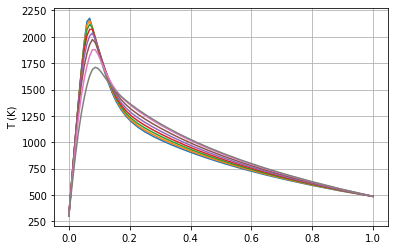

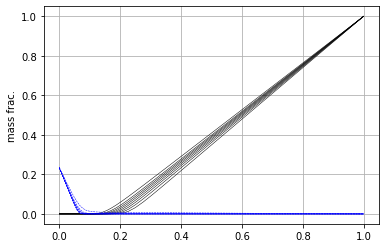

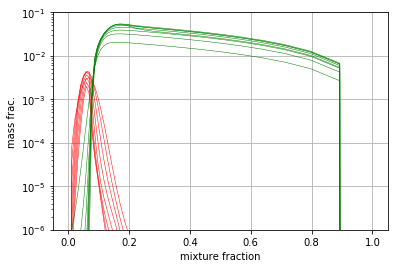

In [2]:
print('adiabatic profiles')
plt.plot(lib.mixture_fraction_values, lib['temperature'][:, :, 0])
plt.ylabel('T (K)')
plt.grid()
plt.show()
plt.plot(lib.mixture_fraction_values, lib['mass fraction NXC7H16'][:, :, 0], 'k-', linewidth=0.5)
plt.plot(lib.mixture_fraction_values, lib['mass fraction O2'][:, :, 0], 'b--', linewidth=0.5)
plt.ylabel('mass frac.')
plt.grid()
plt.show()
plt.plot(lib.mixture_fraction_values, lib['mass fraction OH'][:, :, 0], 'r-', linewidth=0.5)
plt.plot(lib.mixture_fraction_values, lib['mass fraction C2H2'][:, :, 0], 'g-', linewidth=0.5)
plt.yscale('log')
plt.ylim([1.e-6, 1e-1])
plt.ylabel('mass frac.')
plt.xlabel('mixture fraction')
plt.grid()
plt.show()

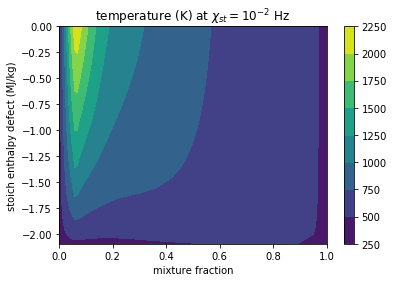

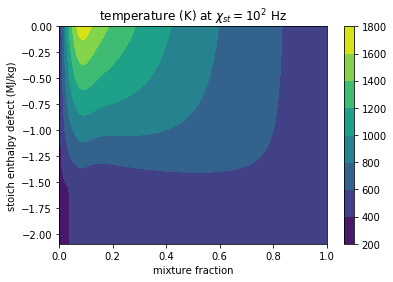

In [4]:
T = lib['temperature']

plt.contourf(lib.mixture_fraction_grid[:, 0, :], lib.enthalpy_defect_stoich_grid[:, 0, :] / 1.e6, T[:, 0, :])
plt.colorbar()
plt.title('temperature (K) at $\\chi_{st}=10^{-2}$ Hz')
plt.xlabel('mixture fraction')
plt.ylabel('stoich enthalpy defect (MJ/kg)')
plt.show()
plt.contourf(lib.mixture_fraction_grid[:, -1, :], lib.enthalpy_defect_stoich_grid[:, -1, :] / 1.e6, T[:, -1, :])
plt.colorbar()
plt.title('temperature (K) at $\\chi_{st}=10^{2}$ Hz')
plt.xlabel('mixture fraction')
plt.ylabel('stoich enthalpy defect (MJ/kg)')
plt.show()

Here is an example of a Cantera `SolutionArray` being used to compute production rates to tabulate on the library. With code like this one could tabulate any Cantera method such as production rates, reaction rates, species enthalpies, etc., and functions thereof, with ease.

In [7]:
def make_solution_array(library, pressure):
    lib_shape = library['temperature'].shape
    nstates = library['temperature'].size
    Y = np.ndarray((nstates, mech.n_species))
    for i, name in enumerate(mech.species_names):
        Y[:, i] = lib['mass fraction ' + name].ravel()
    states = ct.SolutionArray(mech.gas, (nstates,))
    states.TPY = library['temperature'].ravel(), pressure, Y
    return states

In [8]:
ct_sa = make_solution_array(lib, pressure)

w = ct_sa.net_production_rates
lib['prod_rate_co_co2'] = (w[:, mech.species_index('CO')] + w[:, mech.species_index('CO2')]).reshape(lib_shape)

Finally, this shows how one can do arbitrary calculations with library datasets because they're just NumPy arrays. This particular instance builds a rate function involving temperature and concentrations of heptane and oxygen.

In [9]:
rho = lib['density']
c_heptane = rho * lib['mass fraction NXC7H16'] / mech.molecular_weight('NXC7H16')
c_o2 = rho * lib['mass fraction O2'] / mech.molecular_weight('O2')
k = 5.1e11 * T * np.exp(- (30. * 4.184e6) / (ct.gas_constant * T))
lib['my_global_1step_rxn_rate'] = k * c_heptane ** 0.25 * c_o2 ** 1.5